In [1]:
import shutil
root_dir = "/kaggle/input/ccaiunict-2023"
print(root_dir)

try:
    shutil.rmtree("/kaggle/working/train")
    shutil.rmtree("/kaggle/working/test")
except:
    pass

/kaggle/input/ccaiunict-2023


In [2]:
import torch

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(dev)

cuda


In [3]:
import pandas as pd

train_data = pd.read_csv('/kaggle/input/ccaiunict-2023/train.csv')
test_data = pd.read_csv('/kaggle/input/ccaiunict-2023/test.csv')


In [4]:
import torchvision.transforms as T

norm_mean = (0.485, 0.456, 0.406)
norm_std = (0.229, 0.224, 0.225)
transform = T.Compose([       
    T.ColorJitter(brightness=[0.8, 1.2], contrast=[0.8, 1.2], saturation=[0.5, 1.5], hue=0.5),
    T.Normalize(mean= norm_mean, std= norm_std),
    T.RandomRotation(degrees=[-15, 15]),
    T.RandomHorizontalFlip(),
    T.ToTensor()
])

In [5]:
import matplotlib.pyplot as plt
import os
import re

def crop_image(input_path, output_path, data):
    
    for _, row in data.iterrows():
        image_name = row['image']
        x_min = row['x1']
        y_min = row['y1']
        x_max = row['x2']
        y_max = row['y2']

        image_path = input_path + image_name
        image = Image.open(image_path)

        cropped_image = image.crop((x_min, y_min, x_max, y_max))
        
        check_input = re.findall(r"/([^/]+)/$", input_path)[0]
        if check_input == 'train':
            _class = re.findall(r"^([^/]+)/", image_name)[0]
            dir_path = os.path.join(output_path, _class)
            os.makedirs(dir_path, exist_ok=True) 
        else:
            os.makedirs(output_path, exist_ok=True)
        
        cropped_image.save(os.path.join(output_path, image_name))    

In [6]:
train_input_path = "/kaggle/input/ccaiunict-2023/train/"
test_input_path = "/kaggle/input/ccaiunict-2023/test/"

train_output_path = "/kaggle/working/train"
test_output_path = "/kaggle/working/test"

crop_image(train_input_path, train_output_path, train_data)
crop_image(test_input_path, test_output_path, test_data)


In [7]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder('/kaggle/working/train', transform = transform)

In [10]:
from torch.utils.data import Dataset
from PIL import Image

#An abstract class representing a Dataset.
#All datasets that represent a map from keys to data samples should subclass it. 
#All subclasses should overwrite __getitem__(), supporting fetching a data sample for a given 
#key. Subclasses could also optionally overwrite __len__(), which is expected to return the 
#size of the dataset by many Sampler implementations and the default options of DataLoader. --> Documentation pytorch Dataset Class

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = os.listdir(root_dir)
        
    def __len__(self):
           return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image

In [ ]:
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

batch_size = 16

test_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=norm_mean, std=norm_std)
])

dataset= train_dataset
test_dataset = ImageDataset('/kaggle/working/test', transform=test_transform)

train_dataset, val_dataset = train_test_split(dataset, test_size=0.25, random_state=42)

print("Numero di campioni nel set di addestramento:", len(train_dataset))
print("Numero di campioni nel set di convalida:", len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size, num_workers=2, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size, num_workers=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [ ]:
print(train_dataset[0][0].size())

torch.Size([3, 127, 127])


In [12]:
print(test_dataset[0][0].size())

torch.Size([127, 127])


In [13]:
loaders = {"train": train_loader,
           "val": val_loader
          }

In [14]:
import torchvision.models as models
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        efficientnet = models.efficientnet_v2_l(pretrained=True)

        self.features = efficientnet.features

        self.fc_layers = nn.Sequential(
            nn.Linear(20480, 2480),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2480, 620),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(620, 8)
        )

    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [15]:
model = CNN()

test_input = train_dataset[0][0].unsqueeze(0)
print("Model output size:", model(test_input).size())

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:07<00:00, 66.9MB/s]


Model output size: torch.Size([1, 8])


In [16]:
import torch.optim as optim

CNN_optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
def train(model, criterion, epochs, optimizer,dev):
    try:
        model = model.to(dev)
        history_loss = {"train": [], "val": []}
        history_accuracy = {"train": [], "val": []}
        for epoch in range(epochs):
            sum_loss = {"train": 0, "val": 0}
            sum_accuracy = {"train": 0, "val": 0}
            for split in ["train", "val"]:
                if split == 'train': 
                    model.train()
                else: 
                    model.eval()
                for (input, labels) in loaders[split]:
                    input = input.to(dev)
                    labels = labels.to(dev)
                    optimizer.zero_grad()
                    pred = model(input)
                    loss = criterion(pred, labels)
                    sum_loss[split] += loss.item()
                    _,pred_labels = pred.max(1)
                    batch_accuracy = (pred_labels == labels).sum().item()/input.size(0)
                    sum_accuracy[split] += batch_accuracy
                    if split == "train":
                        loss.backward()
                        optimizer.step()
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val"]}
            for split in ["train", "val"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            print(f"Epoch {epoch+1}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},")
    except KeyboardInterrupt:
            print("Interrupted")
    finally:
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val"]:
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val"]:
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()

CNN(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
           

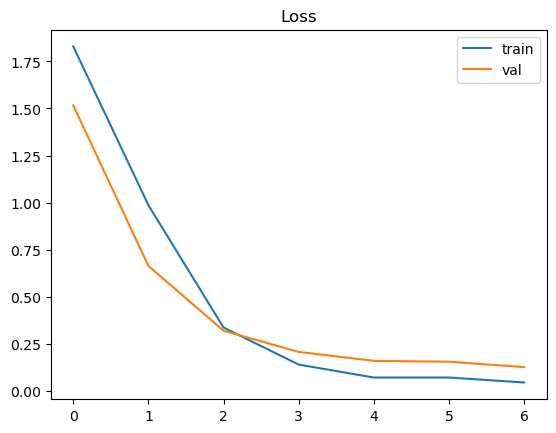

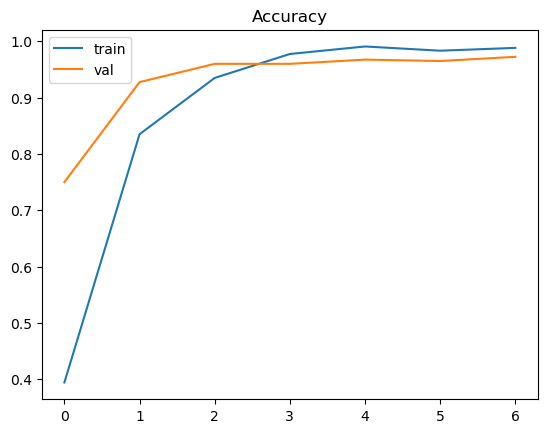

In [20]:
train(model, criterion, 7, CNN_optimizer, dev)

tensor([[-0.8472, -0.9383, -0.3701,  5.9279, -0.0765, -0.2991, -0.0582,  0.8541]],
       device='cuda:0')
Predicted: 3 (correct: 3)


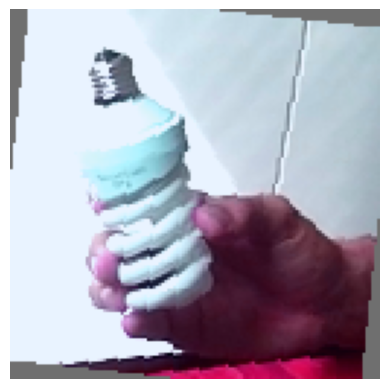

In [21]:
import random
import numpy 

idx = random.randint(0, len(val_dataset)-1)
input, label = val_dataset[idx]

input_show = (input - input.min())/(input.max() - input.min())
plt.imshow(input_show.permute(1,2,0).numpy())
plt.axis('off')

model.eval()
with torch.no_grad():
    output = model(input.unsqueeze(0).to(dev))
    print(output)
_,pred = output.max(1)
pred = pred.item()
print(f"Predicted: {pred} (correct: {label})")

       image  class
490  000.jpg      3
689  001.jpg      0
594  002.jpg      3
403  003.jpg      4
79   004.jpg      0
363  005.jpg      5
624  006.jpg      0
789  007.jpg      7
224  008.jpg      0
449  009.jpg      2
511  010.jpg      2
187  011.jpg      3
378  012.jpg      4
525  013.jpg      1
519  014.jpg      7
541  015.jpg      6
294  016.jpg      2
582  017.jpg      4
731  018.jpg      6
504  019.jpg      2
418  020.jpg      1
445  021.jpg      5
603  022.jpg      5
181  023.jpg      1
396  024.jpg      0
544  025.jpg      7
703  026.jpg      4
170  027.jpg      1
748  028.jpg      5
651  029.jpg      5
746  030.jpg      4
83   031.jpg      1
355  032.jpg      1
467  033.jpg      5
239  034.jpg      4
454  035.jpg      2
192  036.jpg      2
410  037.jpg      6
489  038.jpg      0
747  039.jpg      6
590  040.jpg      6
72   041.jpg      1
649  042.jpg      4
415  043.jpg      4
792  044.jpg      4
273  045.jpg      0
208  046.jpg      6
475  047.jpg      6
459  048.jpg      3


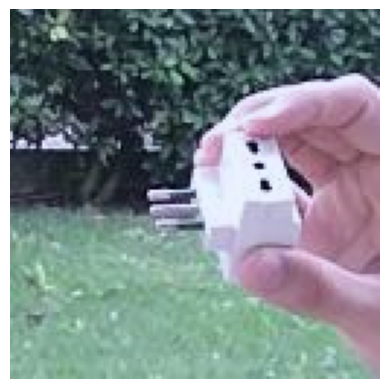

In [22]:
predictions = []
model.eval()

for image in range(len(test_dataset)):
    input = test_dataset[image]

    input_show = (input - input.min()) / (input.max() - input.min())
    plt.imshow(input_show.permute(1, 2, 0).numpy())
    plt.axis('off')

    with torch.no_grad():
        output = model(input.unsqueeze(0).to(dev))

    _, pred = output.max(1)
    pred = pred.item()

    image_name = test_dataset.images[image]
    predictions.append({'image': image_name, 'class': pred})

predictions_df = pd.DataFrame(predictions)
predictions_df_sorted = predictions_df.sort_values(by='image', ascending=True)

print(predictions_df_sorted.to_string())

predictions_df_sorted.to_csv("/kaggle/working/submission.csv", index=False)

